# Module 04: Assignment for 2-Dimensional Landscape Evolution Model

# Name: Yao Gahounzo

## Overview and Requirements

In this assignment you will examine the long term behavior of the elevation field under two different assumptions about the landscape diffusivity (i.e., the variable controlling soil creep). Use the code below to conduct the following experiments:

__Experiment 1:__ Using the code below conduct an experiment that leaves everything unchanged, except `tf` which you should increase to 100,000 yrs and increasing the plotting output interval (`OutputInterval`) to 20,000 years. Run the model and also create an array that is `Nt` in length to store the maximum elevation in the 2-D domain at each time step. You will need to use the `.max` function on `hnext` to obtain this inside the main `for` loop of the model.

__Experiment 2:__ Using the same setup as you did for Experiment 1 above, now _decrease_ the diffusivity `D` by an order of magnitude and re-run the model, again keeping track of the maximum elevation in the domain at each modeling time step. 

The notebook you turn in should have the following plots:
* The maximum elevation versus time for both experiments on the same plot
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 1__ (clearly labelled)
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 2__ (clearly labelled)

Answer the following question:
* How does changing the diffusivity change the evolution of the maximum elevation in each experiment? 
* If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0 # (m)

D1 = 2.5 # (m^2/yr) for expt 1
D2 = 0.25 # (m^2/yr) for expt 2

ti = 0.0 # (yr)
tf = 100000.0 # (yr)
dt = 5 # (yr)

# Uplift rate (m/yr)
U = 0.005 # (m/yr)

# Plotting options
individual_plots = 0 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 20000.0 # (yr)

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

## Compute the Stability Variable 

In [2]:
alpha1 = D1*dt/dx**2
print("alpha = ",alpha1)
print("dt = ",dt)
print("dx = ",dx)
if alpha1 >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.12005000000000002
dt =  5
dx =  10.204081632653061


In [3]:
#for expt2
alpha2 = D2*dt/dx**2
print("alpha2 = ",alpha2)
print("dt = ",dt)
print("dx = ",dx)
if alpha2 >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha2 =  0.012005000000000002
dt =  5
dx =  10.204081632653061


## Setup the Solver Matrix

In [4]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))


## Setup the Boundary Conditions

In this problem, the boundary conditions are a little more complex. We will assume that the elevation at the corder of our square domain remain fixed throughout the simulation. But the rest of the area along the edges of the domain can evolve. 

What we need to do to allow this is actually first solve the 1-D problem once (using the same $\Delta x$, $D$, $\Delta t$, and simulation duration) on the edges of the domain with fixed edges, and then use that solution at every time step along ___all four___ edges of the domain. 

In [5]:
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))
    
def bc(alpha):
    H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

    H_1D[:,0] = np.matrix(h0_1D)

    for i in range(1,int(Nt)):
        hinit_1D = H_1D[:,i-1] 

        hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
        hnext_1D[0] = hi
        hnext_1D[-1] = hi

        H_1D[:,i] = hnext_1D[:,0]
    return H_1D

## Run the Model

Now we need to run the model. Here we use an explicit approach to the solution, but we pose it as a linear algebra matrix-vector multiplication (i.e., we don't have to invert the matrix $\mathbf{A}$. We will create a 3-D plot at fixed intervals along the simulation... it's too much to visualize each timestep. You can control how often plots are created using the variable `OutputInterval`. 

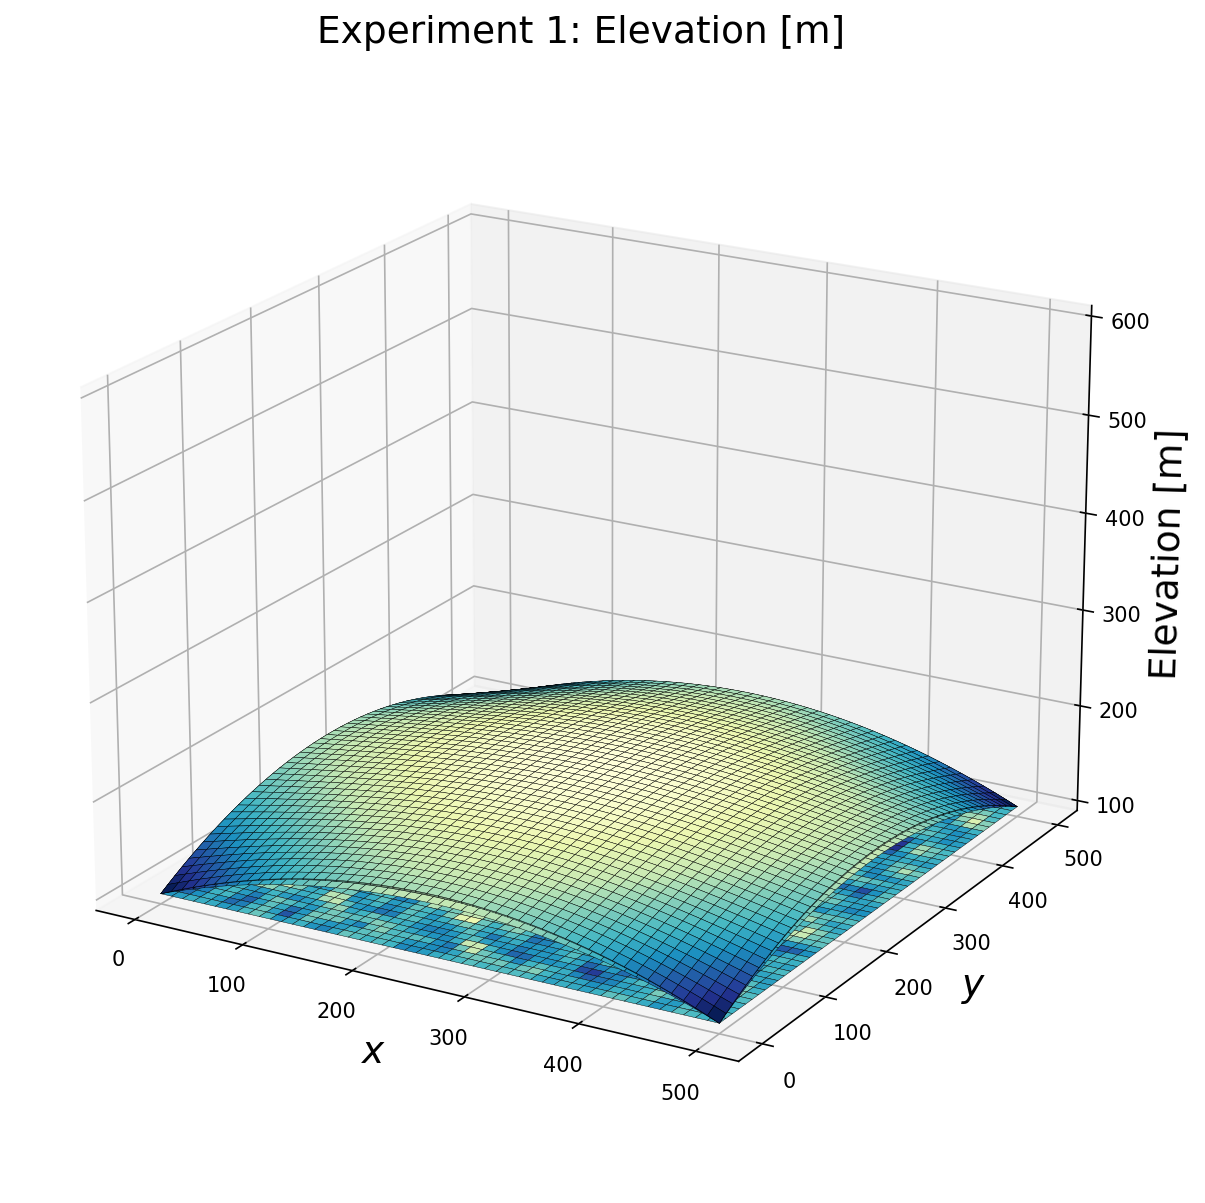

In [6]:
import matplotlib as mpl

H_1D = bc(alpha1)

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)
max_elevation1 = np.zeros(int(Nt)) # stores max elevation
max_elevation1[0] = hnext.max()    # Maximum elevation in the initial solution

figcounter = 1


for i in range(1,int(Nt)):
    hinit = hnext + U*dt
    
    hnext = hinit + alpha1*Delta2*hinit 

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    max_elevation1[i] = hnext.max()     # Maximum elevation in solution at the i-th time step
    
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Experiment 1: Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

In [7]:
# Second experiment: decrease the diffusivity D by an order of magnitude

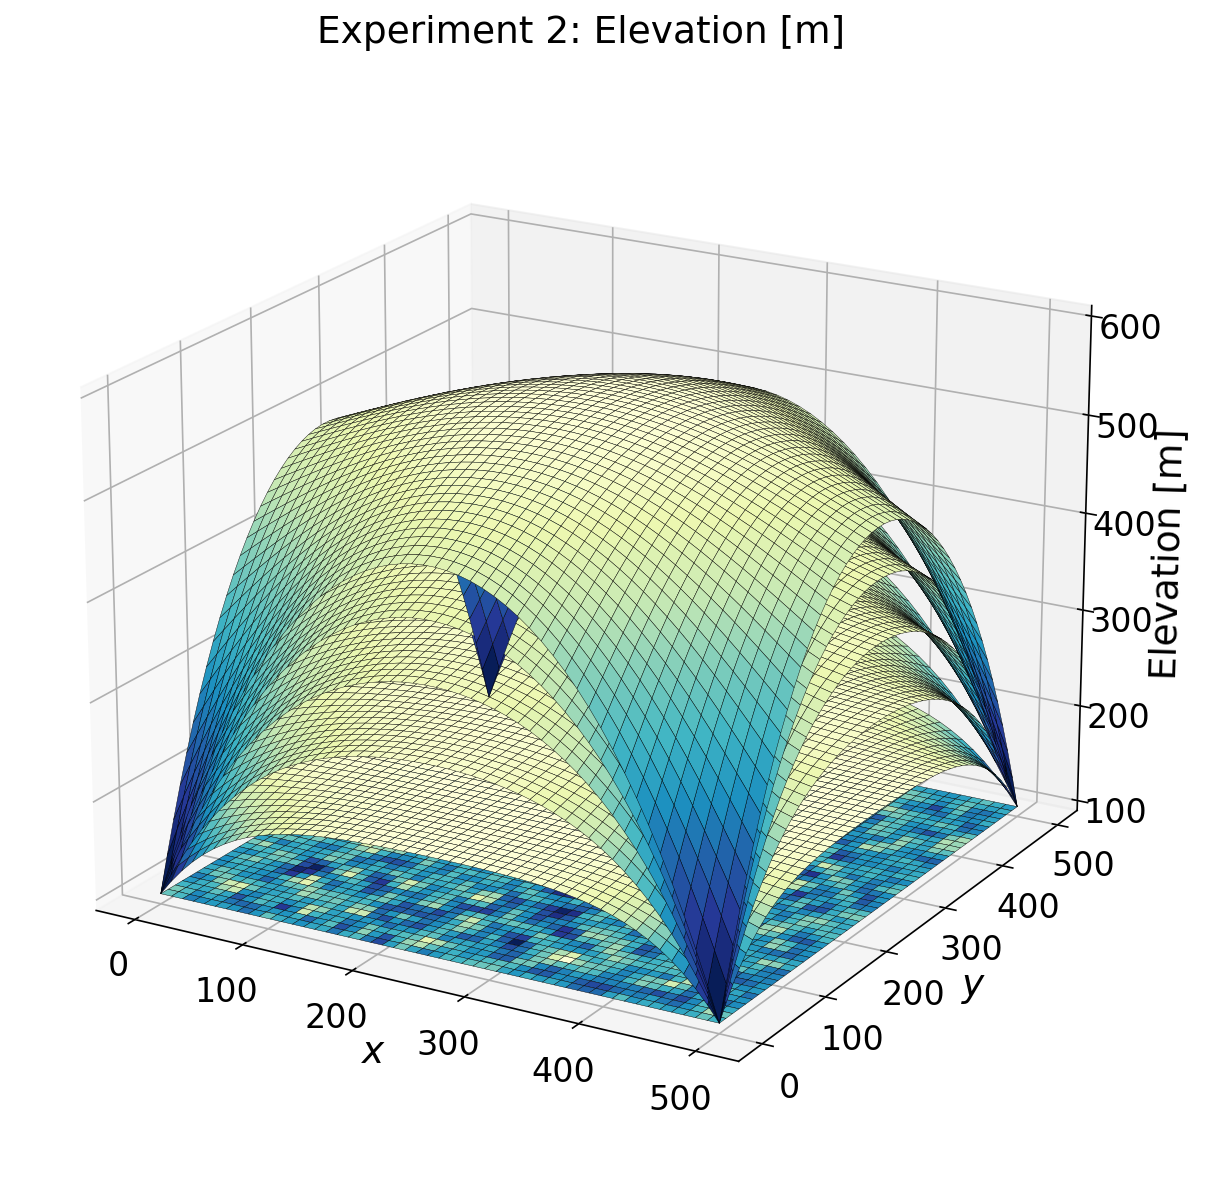

In [8]:
H_1D = bc(alpha2)

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)
max_elevation2 = np.zeros(int(Nt)) # stores max elevation
max_elevation2[0] = hnext.max()    # Maximum elevation in the initial solution

figcounter = 1


for i in range(1,int(Nt)):
    hinit = hnext + U*dt
    
    hnext = hinit + alpha2*Delta2*hinit 

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    max_elevation2[i] = hnext.max() # Maximum elevation in solution at the i-th time step
    
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Experiment 2: Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

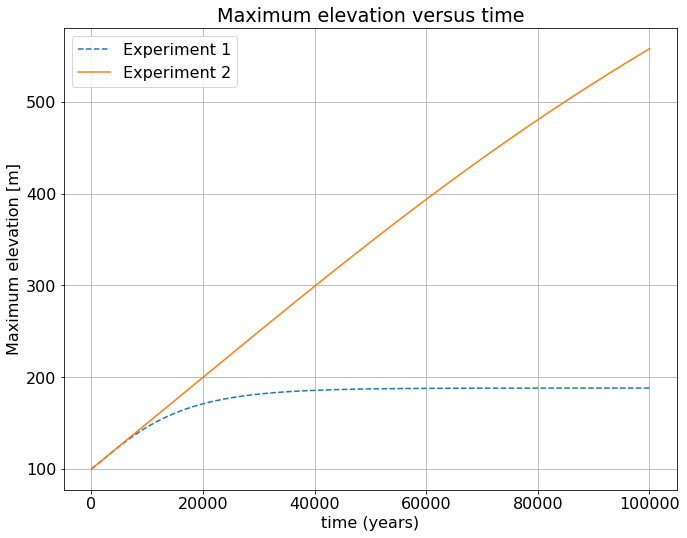

In [9]:
t = np.linspace(ti,tf,int(Nt))

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(11.0,8.5))
plt.plot(t,max_elevation1,'--',label='Experiment 1')  # Plot of the maximum elevation in experiment 1
plt.plot(t,max_elevation2,'-',label='Experiment 2')   # Plot of the maximum elevation in experiment 2
plt.grid()
plt.xlabel('time (years)')                        # x-label
plt.ylabel('Maximum elevation [m]')               # y-label
plt.legend()
plt.title('Maximum elevation versus time')        # title
plt.show()


### 

How does changing the diffusivity change the evolution of the maximum elevation in each experiment? 


The maximum elevation in Experiment 1 increases from 100 m elevation to 180 and then remains constant over time. Decreasing the diffusivity by one order, the maximum elevation in Experiment 2 is almost the same as in Experiment 1 up to 150 m but detaches and remains almost linear with increasing time. Decreasing the diffusivity reduces the diffusion term of the equation, making the scheme expensive but computationally efficient and stable.



If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?

The maximum elevation in both experiments is almost the same from the beginning. However, it begins to separate from each other around 10,000 years. This discrepancy increases with time, leaving the maximum elevation in Experiment 1 almost constant over time, small than that of Experiment 2, which increases with time. Therefore, if both experiments run for an infinite amount of time, the topographic surface in Experiment 1 will remain smaller than that in Experiment 2.

The difference is that the maximum elevation of Experiment 1 will remain constant over time, while that of Experiment 2 will increase almost linearly. Hence making big difference in both topographies.

